### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [6]:
import HPO
import pysgpp
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
from sklearn.model_selection import KFold
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from numpy.random import seed
import random
import time
import os
import math

random.seed(1)
seed(2)
tf.random.set_seed(3)

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    tf.random.set_seed(3)

VERBOSE = 1
CV = 2 #[(slice(None), slice(None))]
TESTING = True 

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [7]:
hyperparameterspace = {
    'epochs': ["interval-int", 1, 40],
    #'batch_size': ["interval-int", 1, 200],
    'learning_rate': ["interval-log", 0.000000001, 0.1],
    #'number_layers': ["interval-int", 1, 20],
    #'neurons_per_layer': ["interval-int", 1, 50]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste



### Model definition

In [8]:

def create_model(learning_rate=0.0001, input_dim=10, number_layers=1, neurons_per_layer=20):
    # create model
    model = Sequential()

    model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation='relu'))
    for _ in range(number_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation=None))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


### Experiment parameters

In [9]:
DIRECTORY = "Current_tests/"+time.strftime("%H_%M_%S", time.localtime())

SPARSE_PARAMS = [2, 0.85, "gradient_descent"]

ITER = 20
BUDGETS = [(2 * x) + 1 for x in range(ITER)]

for i in range(3):
    BUDGETS.append((i+1)**len(hyperparameterspace))

BUDGETS = list(set(BUDGETS))
BUDGETS.sort()

BUDGETS = [40]

### Optimization

In [10]:
# os.mkdir(DIRECTORY)

# f = open(DIRECTORY+"/configurations.txt", "a")
# f.write("Dimension of hyperparameter space: " +
#         str(len(hyperparameterspace)) + "\n")
# for key in hyperparameterspace.keys():
#     f.write("\n" + key + ": " + str(hyperparameterspace[key]))
# f.write("\n\nSparse grid degree: " + str(SPARSE_PARAMS[0]))
# f.write("\nSparse grid adaptivity param: " + str(SPARSE_PARAMS[1]))
# f.write("\nSparse grid optimization alg: " + str(SPARSE_PARAMS[2]))
# f.write("\nBUDGETS: " + str(BUDGETS))
# f.close()

ids = [233211]  # , 359952, 359931, 359949, 359938]
# [359940, 317614, 359934, 359946, 359932, 233214, 359943]

for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    print("The average value for target is:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))

    current_dataset_grid = []
    current_dataset_random = []
    current_dataset_bayesian = []
    current_dataset_sparse = []
    current_dataset_sparse_opt = []

    current_dataset_grid_cost = []
    current_dataset_random_cost = []
    current_dataset_bayesian_cost = []
    current_dataset_sparse_cost = []
    current_dataset_sparse_opt_cost = []

    ################## MODEL AND FUNCTION DEFINITION ####################

    def evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer, deterministic=True):

        kfold = KFold(n_splits=CV)

        split = (kfold.split(dataset.get_X(), dataset.get_Y()))

        values = []

        numeric_features = [not x for x in dataset.get_categorical_indicator()]
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())]
        )

        categorical_transformer = Pipeline(
            steps=[
                ("encoder", OneHotEncoder(
                    handle_unknown="infrequent_if_exist", sparse_output=False)),
                # ("selector", SelectPercentile(chi2, percentile=50)),
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer,
                 dataset.get_categorical_indicator()),
            ]
        )

        for i, (train_index, test_index) in enumerate(split):

            if deterministic:
                reset_seeds()

            X_train = dataset.get_X()[train_index]
            Y_train = dataset.get_Y()[train_index]

            X_val = dataset.get_X()[test_index]
            Y_val = dataset.get_Y()[test_index]

            preprocessor.fit(X_train, Y_train)

            X_train = preprocessor.transform(X_train)
            X_val = preprocessor.transform(X_val)

            regressor = KerasRegressor(model=create_model,
                                       learning_rate=learning_rate,
                                       input_dim=len(
                                           X_train[0]),
                                       number_layers=number_of_layers,
                                       neurons_per_layer=neurons_per_layer,
                                       verbose=0)

            regressor = TransformedTargetRegressor(regressor=regressor,
                                                   transformer=StandardScaler())

            regressor.fit(X_train, Y_train, epochs=int(epochs),
                          batch_size=int(batch_size), shuffle=False)

            Y_predicted = regressor.predict(X_val)
            # error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
            error = sklearn.metrics.mean_absolute_percentage_error(
                Y_predicted, Y_val)
            values.append(error)

            del regressor
            K.clear_session()

        result = sum(values)/len(values)
        return result

    # def blackboxfunction_grid(params):
    #     # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
    #     # hyperparameterspace_special["loss"][index]

    #     epochs = int(params[0])

    #     batch_size = int(params[1])

    #     learning_rate = 1 # params[2]

    #     number_of_layers = 1  # int(params[3])

    #     neurons_per_layer = 40  # int(params[4])

    #     return evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer)

    # def blackboxfunction_random(params):
    #     # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
    #     # hyperparameterspace_special["loss"][index]

    #     epochs = int(params[0])

    #     batch_size = int(params[1])

    #     learning_rate = 1 # params[2]

    #     number_of_layers = 1  # int(params[3])

    #     neurons_per_layer = 40  # int(params[4])

    #     return evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer, deterministic=False)

    # def blackboxfunction_bayesian(params):
    #     # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
    #     # hyperparameterspace_special["loss"][index]

    #     epochs = int(params[0])

    #     batch_size = int(params[1])

    #     model_learning_rate = 1 #10 ** (params[2])

    #     number_of_layers = 1  # int(params[3])

    #     neurons_per_layer = 40  # int(params[4])

    #     return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer, deterministic=False)

    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(
                len(hyperparameterspace.keys()))

        def eval(self, x):
            # index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            # hyperparameterspace_special["loss"][index]

            epochs = int(HPO.from_standard(
                hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = 100  # int(HPO.from_standard(
            # hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            # HPO.from_standard_log(hyperparameterspace_special["learning_rate"][
            model_learning_rate = HPO.from_standard_log(
                hyperparameterspace_special["learning_rate"][0], hyperparameterspace_special["learning_rate"][1], x[1])

            number_of_layers = 1  # int(HPO.from_standard(
            # hyperparameterspace_special["number_layers"][0], hyperparameterspace_special["number_layers"][1], x[3]))

            neurons_per_layer = 40  # int(HPO.from_standard(
            # hyperparameterspace_special["neurons_per_layer"][0], hyperparameterspace_special["neurons_per_layer"][1], x[4]))

            return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)

    ##### For each dataset: run models with different budget #####
    for BUDGET in BUDGETS:

        print("\n################################################## Current Budget:",
              BUDGET, "##################################################")

        # ############################## GRID SEARCH #######################
        # grid_sizes = [x ** len(hyperparameterspace) for x in range(9)]
        # if BUDGET in grid_sizes:
        #     print("\nPerforming grid search")
        #     optimization = HPO.GridSearchOptimization(
        #         dataset, blackboxfunction_grid, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        #     result, cost = optimization.fit()

        #     index_best = 0
        #     for m in range(len(result)):
        #         if result[m][1] < result[index_best][1]:
        #             index_best = m

        #     best_score = result[index_best][1]
        #     best_params = result[index_best][0]

        #     if VERBOSE > 0:
        #         print("With Hyperparameters: ")
        #         m = 0
        #         for key in hyperparameterspace.keys():
        #             if hyperparameterspace[key][0] == "list":
        #                 index = int(
        #                     best_params[m]*(len(hyperparameterspace_special[key])-1))
        #                 print(key + ": " +
        #                       str(hyperparameterspace_special[key][index]))
        #             else:
        #                 print(key + ": " + str(best_params[m]))
        #             m += 1

        #     print("Best score with Grid search:", best_score)

        #     current_dataset_grid.append(best_score)
        #     current_dataset_grid_cost.append(cost)

        #     K.clear_session()

        # # ########################### RANDOM SEARCH #######################
        # print("\nPerforming random search")

        # optimization = HPO.RandomSearchOptimization(
        #     dataset, blackboxfunction_random, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        # result, cost = optimization.fit()

        # index_best = 0
        # for m in range(len(result)):
        #     if result[m][1] < result[index_best][1]:
        #         index_best = m

        # best_score = result[index_best][1]
        # best_params = result[index_best][0]

        # if VERBOSE > 0:
        #     print("With Hyperparameters: ")
        #     m = 0
        #     for key in hyperparameterspace.keys():
        #         if hyperparameterspace[key][0] == "list":
        #             index = int(
        #                 best_params[m]*(len(hyperparameterspace_special[key])-1))
        #             print(key + ": " +
        #                   str(hyperparameterspace_special[key][index]))
        #         else:
        #             print(key + ": " + str(best_params[m]))
        #         m += 1

        # print("Best score with Random search:", best_score)

        # current_dataset_random.append(best_score)
        # current_dataset_random_cost.append(cost)

        # K.clear_session()

        # ########################### BAYESIAN OPT #####################
        # print("\nPerforming bayesian optimization")

        # optimization = HPO.BayesianOptimization(
        #     dataset, blackboxfunction_bayesian, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)

        # result, cost = optimization.fit()

        # index_best = 0
        # for m in range(len(result)):
        #     if result[m][1] < result[index_best][1]:
        #         index_best = m

        # best_score = result[index_best][1]
        # best_params = result[index_best][0]

        # if VERBOSE > 0:
        #     print("With Hyperparameters: ")
        #     m = 0
        #     for key in hyperparameterspace.keys():
        #         if hyperparameterspace[key][0] == "list":
        #             index = int(
        #                 best_params[m]*(len(hyperparameterspace_special[key])-1))
        #             print(key + ": " +
        #                   str(hyperparameterspace_special[key][index]))
        #         elif hyperparameterspace[key][0] == "interval-log":
        #             print(key + ": " + str(10 ** best_params[m]))
        #         else:
        #             print(key + ": " + str(best_params[m]))
        #         m += 1

        # print("Best score with Bayesian Optimization:", best_score)

        # current_dataset_bayesian.append(best_score)
        # current_dataset_bayesian_cost.append(BUDGET)

        # K.clear_session()

        ########################### SPARSE OPT ############################

        print("\nPerforming sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(
            dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=SPARSE_PARAMS[0], adaptivity=SPARSE_PARAMS[1], optimizer=SPARSE_PARAMS[2])

        [x0, fX0, x1, fX1, x2, fX2], cost = optimization.fit()

        print("x0")
        print(x0)
        print(fX0)

        print("x1")
        print(x1)
        print(fX1)

        print("x2")
        print(x2)
        print(fX2)

        # print("Best score with Sparse Search:",
        #       result[0][1], "optimized:", result[0][3])

        # current_dataset_sparse.append(result[0][1])
        # current_dataset_sparse_opt.append(result[0][3])

        # current_dataset_sparse_cost.append(result[1])
        # current_dataset_sparse_opt_cost.append(result[1]+1)

        K.clear_session()

        print(current_dataset_grid)
        print(current_dataset_random)
        print(current_dataset_bayesian)
        print(current_dataset_sparse)
        print(current_dataset_sparse_opt)

    GRID_RESULT.append(current_dataset_grid)
    RANDOM_RESULT.append(current_dataset_random)
    BAYESIAN_RESULT.append(current_dataset_bayesian)
    SPARSE_RESULT.append(current_dataset_sparse)
    SPARSE_RESULT_OPTIMIZED.append(current_dataset_sparse_opt)

    GRID_COST.append(current_dataset_grid_cost)
    RANDOM_COST.append(current_dataset_random_cost)
    BAYESIAN_COST.append(current_dataset_bayesian_cost)
    SPARSE_COST.append(current_dataset_sparse_cost)
    SPARSE_COST_OPTIMIZED.append(current_dataset_sparse_opt_cost)

    print("###################### Current dataset",
          ids[i], "######################")

    dataset = HPO.Dataset(task_id=ids[i])

    print("Target average:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))

    # plotting the points
    plt.plot(GRID_COST[i], GRID_RESULT[i], '.-',
             color='black', label="Grid search")
    plt.plot(RANDOM_COST[i], RANDOM_RESULT[i], '.-',
             color='red', label="Random search")
    plt.plot(BAYESIAN_COST[i], BAYESIAN_RESULT[i], '.-',
             color='blue', label="Bayesian Optimization")
    plt.plot(SPARSE_COST[i], SPARSE_RESULT[i], '.-',
             color='purple', label="Sparse Grid search")
    plt.plot(SPARSE_COST_OPTIMIZED[i], SPARSE_RESULT_OPTIMIZED[i],
             '.-', color='pink', label="Sparse Grid search (opt)")

    # naming the x axis
    plt.xlabel('Function evaluations')
    # naming the y axis
    plt.ylabel('Mean absolute percentage')

    # show a legend on the plot
    plt.legend()

    # plt.savefig(DIRECTORY + "/task_id" + str(ids[i]))
    # function to show the plot
    plt.show()


######################################################################################################################################################
Current Dataset: 1 of 1 with id: 233211
The average value for target is: tensor([3932.8892])
Min target: tensor([326.]) Max target: tensor([18823.])

################################################## Current Budget: 40 ##################################################

Performing sparse search
Adaptive grid generation (Ritter-Novak)...


### Print lines

###################### Current dataset 233211 ######################
Target average: tensor([3932.8892])
Min target: tensor([326.]) Max target: tensor([18823.])


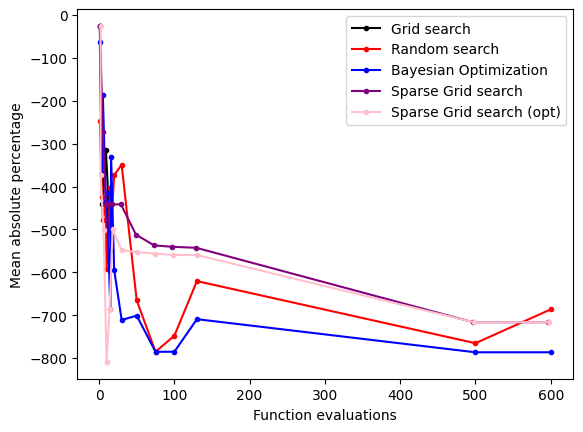

In [ ]:
for i in range(len(ids)):
    print("###################### Current dataset", ids[i], "######################")
    
    dataset = HPO.Dataset(task_id=ids[i])
    
    print("Target average:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))


    # plotting the points 
    plt.plot(GRID_COST[i], GRID_RESULT[i], '.-', color='black', label="Grid search")
    plt.plot(RANDOM_COST[i], RANDOM_RESULT[i], '.-', color='red', label="Random search")
    plt.plot(BAYESIAN_COST[i], BAYESIAN_RESULT[i], '.-', color='blue', label="Bayesian Optimization")
    plt.plot(SPARSE_COST[i], SPARSE_RESULT[i], '.-', color='purple', label="Sparse Grid search")
    plt.plot(SPARSE_COST_OPTIMIZED[i], SPARSE_RESULT_OPTIMIZED[i], '.-', color='pink', label="Sparse Grid search (opt)")
    
    # naming the x axis
    plt.xlabel('Function evaluations')
    # naming the y axis
    plt.ylabel('Mean absolute percentage')
    
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()